In [114]:
%matplotlib widget

import scipy.stats as st
import scipy.signal as ss
from tqdm import tqdm
import numpy as np
import lightkurve as lk 
import pandas as pd 
from numpy.fft import fft, ifft
import astropy.units as au
import astropy.constants as ac
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from celerite2.numpy import GaussianProcess
from scipy.interpolate import PchipInterpolator
from celerite2 import terms
np.random.seed(427)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# get TESS time grid
times_real  = np.loadtxt('/Users/neisner/Documents/code/WtLSP/data/TIC55525572_yr3.txt').T
in_window = (times_real > 2140) * (times_real < 2200)
times_real = times_real[in_window]

In [3]:
# identify the big gaps in the TESS time grid

dts = np.diff(times_real)
big = 20. * np.nanmedian(dts)
small = 1.5 * np.nanmedian(dts)
gap_idx = np.where(dts > big)[0]

gap_idx_small = np.where((dts > small) * (dts < big))[0]

gap_start_times = list(times_real[gap_idx])
gap_end_times =   list(times_real[gap_idx + 1])
chunk_start_times = np.array([-np.inf] + gap_end_times)
chunk_end_times = np.array(gap_start_times + [np.inf])

small_gap_start_times = list(times_real[gap_idx_small])
small_gap_end_times =   list(times_real[gap_idx_small + 1])


In [4]:
# make artificial time grids with different properties

# uniform times
times_uniform = np.linspace(times_real[0], times_real[-1], len(times_real))

# 2-minute cadence but gaps
times_big_gaps = np.linspace(times_real[0], times_real[-1], 42923) # magic
I = np.array([True] * len(times_big_gaps))
for s, e in zip(gap_start_times, gap_end_times):
    I[(times_big_gaps > s) * (times_big_gaps < e)] = False
times_big_gaps = times_big_gaps[I]

# drop 120-ish data points
nbad = 120
times_small_gaps = np.linspace(times_real[0], times_real[-1], len(times_real) + nbad)
bad = np.random.randint(len(times_small_gaps), size=nbad)
I = np.array([True] * len(times_small_gaps))
I[bad] = False
times_small_gaps = times_small_gaps[I]

# uniform times with a 2-year gap (30 days + 2 year gap +  30 days)
gap_duration = 2. * 365.25 # add a two year gap

first_ = np.linspace(times_real[0], int(times_real[0]) + 30, int(len(times_real)/2))
second_ = np.linspace(times_real[0] + gap_duration, int(times_real[0]) + 30 + gap_duration, int(len(times_real)/2) + 1)
times_giant_gap = np.concatenate([first_, second_])

giant_gap_start_times = [first_[-1]]
giant_gap_end_times = [second_[0]]

# times distorted by a realistic barycentic correction (lots of magic)
times_barycentric = times_uniform + 6. * (1. / 24. / 60.) * np.cos(2 * np.pi * times_uniform / 365.25)

# check that all of the data sets have the same length
print(len(times_real), len(times_uniform), len(times_big_gaps), len(times_giant_gap), len(times_small_gaps), len(times_barycentric))

37201 37201 37201 37201 37201 37201


In [5]:
# dictionary
times = {'real': times_real, 'uniform': times_uniform,  'small_gaps': times_small_gaps, 'big_gaps': times_big_gaps, 'giant_gap': times_giant_gap, 'barycentric': times_barycentric}

In [6]:
# plotting variables
figsize = (9,5)
#frequency_xlim = [0., 70.]
fontsize = 15

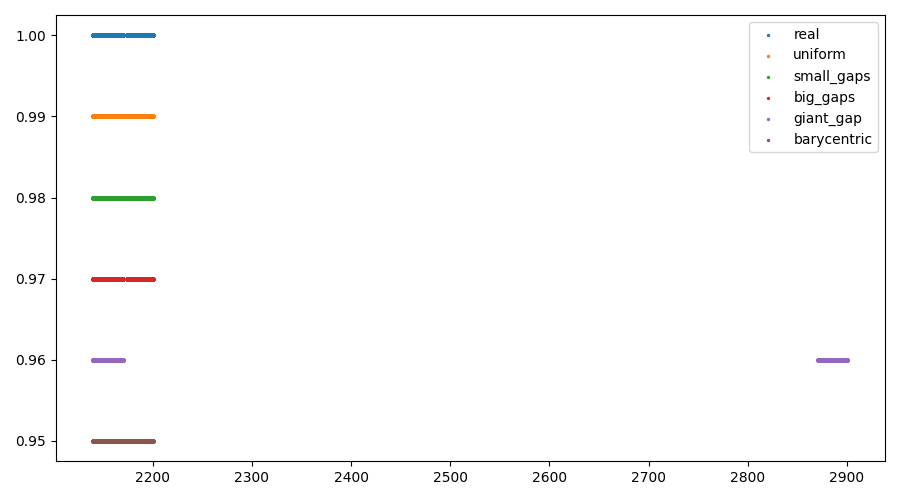

In [7]:
fig, ax = plt.subplots(figsize = figsize)
plt.tight_layout()
for i, key in enumerate(times.keys()):
    ax.scatter(times[key], np.ones_like(times[key]) - i * 0.01, s = 2, label = key)

plt.legend()
plt.tight_layout()

## plot what the data looks like

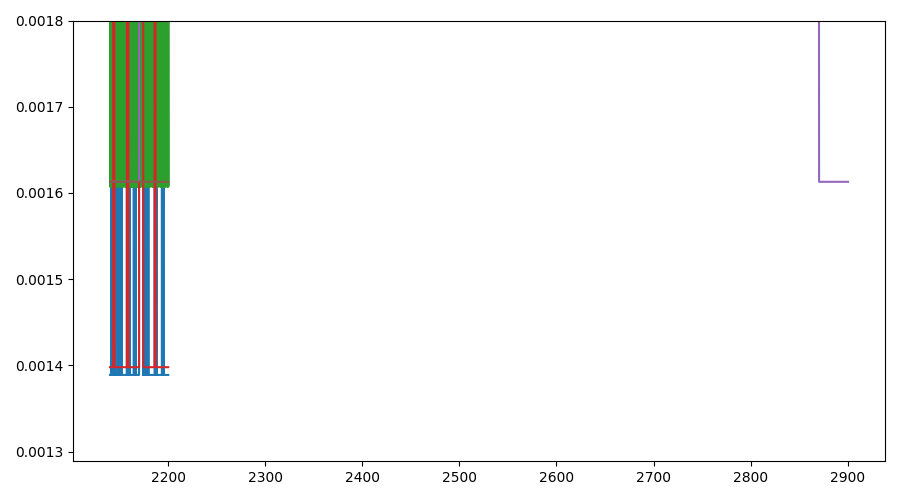

In [8]:
fig, ax = plt.subplots(figsize = figsize)
plt.tight_layout()
for i, key in enumerate(times.keys()):
    ax.plot(times[key][:-1], times[key][1:] - times[key][:-1], ls="-", label=key)
ax.set_ylim(.0012887, .001800)
plt.tight_layout()

In [9]:
# make fake flux data with a few modes
# stupid because writing the same code twice; use lists!

amps =   [0.01] + np.random.uniform(low = 0.00001, high = 0.0001, size = 15).tolist()
omegas = [170] + np.random.uniform(low = 180, high = 350, size = 15).tolist() # this includes the 2 * pi 
phis =   [0.2] + np.random.uniform(low = 0, high = np.pi*2, size = 15).tolist() # this includes the 2 * pi 


#amps = [0.01, 0.000015, 0.00003, 0.000015, ]
#omegas = [170, 300., 310., 320.]
#phis =   [0.2, 0.3, 0.5, 0.3]

def make_flux(times):
    flux = np.ones_like(times)
    for A, om, ph in zip(amps, omegas, phis):
        flux += A * np.cos(om * times + ph)
    flux += 1.e-4 * np.random.normal(size=len(flux))
    return flux

In [10]:
# this shouldn't require so much repetition!
fluxes = {}
for key in times.keys():
    fluxes[key] = make_flux(times[key])

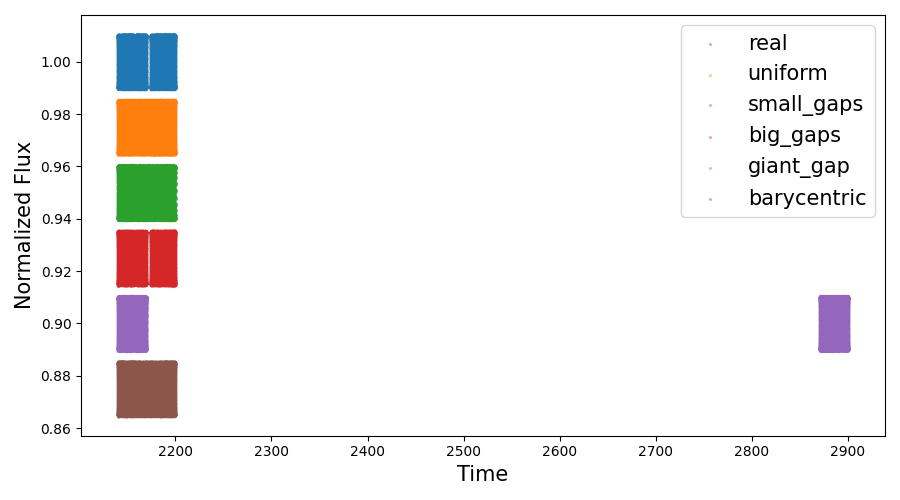

In [11]:
fig, ax = plt.subplots(figsize = figsize)
plt.tight_layout()
for i, key in enumerate(times.keys()):
    ax.scatter(times[key], fluxes[key] - 0.025 * i, s = 2,alpha = 0.3, label=key)

plt.xlabel("Time", fontsize = fontsize)
plt.ylabel("Normalized Flux", fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.tight_layout()
plt.savefig("data_with_without_gaps.png")
plt.show()


In [12]:
# save the data to a file

np.savetxt('/Users/neisner/Documents/code/WtLSP/data/sim_tess_sampling.txt', np.array([times['real'], fluxes['real']]).T)

## Plot the window function

Can we use the window function to predict what signals will be lost?

## Lomb-Scargle

In [13]:
# make a minimal frequency grid
def get_fgrid(times, frequency_oversampling, frequency_xlim):

    deltaf = 1. /(np.max(times) - np.min(times)) / frequency_oversampling

    # set the max frequency to the rough equivalent of Nyquist
    maxf = deltaf * len(times) / 2.

    # or set the max frequency by hand
    maxf = frequency_xlim[-1]

    # run the LS periodogram
    return np.arange(deltaf, maxf, deltaf)


frequency_xlim = [0., 70.]
fgrid = get_fgrid(times_real, 1., frequency_xlim)
fgrid_fine = get_fgrid(times_real, 5., frequency_xlim)

LS_power = {}
for key in times.keys():
    LS_power[key] = LombScargle(times[key], fluxes[key]).power(fgrid)

print(len(fgrid))


4199


In [14]:
infile = '/Users/neisner/Downloads/exofop_tess_tois.csv'

exoplanets = pd.read_csv(infile, comment = '#')

exoplanet_archive = pd.read_csv('/Users/neisner/Downloads/PSCompPars_2024.01.05_10.32.53.csv', comment = '#')

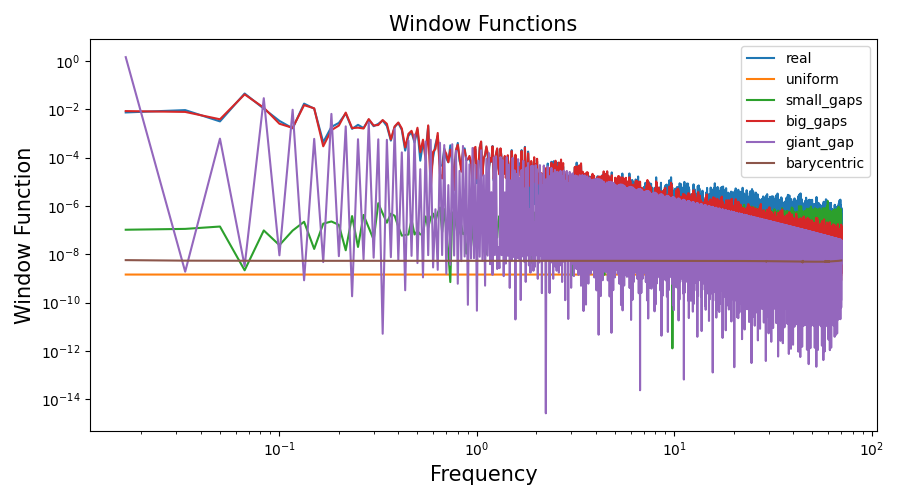

In [15]:
window_funcs = {}
for key in times.keys():
    window_funcs[key] = LombScargle(times[key], np.ones_like(times[key])).power(fgrid)

colors = ['red', 'blue', 'green', 'magenta', 'orange', 'purple']

fig_w, ax_w = plt.subplots(figsize = figsize)
for i,key in enumerate(times.keys()):
    ax_w.loglog(fgrid, window_funcs[key], label = key)
    #ax_w.plot(fgrid, window_funcs[key] + i*0.1, label = key, color = colors[i])
    #ax_w.plot(fgrid * -1, window_funcs[key] + i*0.1,color = colors[i])
    
    
ax_w.set_title("Window Functions", fontsize = fontsize)
ax_w.set_xlabel("Frequency", fontsize = fontsize)
ax_w.set_ylabel("Window Function", fontsize = fontsize)
#ax_w.set_xlim(-0.4,0.4)
ax_w.legend()
fig_w.tight_layout()

The abvove structure (the window function) is what is added around every peak in the power spectrum. This is convolved around every peak int he power spectrum. IN other words, this adds noise and hides signals. 

In [16]:
infile = '/Users/neisner/Downloads/exofop_tess_tois.csv'

exoplanets = pd.read_csv(infile, comment = '#')

exoplanet_archive = pd.read_csv('/Users/neisner/Downloads/PSCompPars_2024.01.05_10.32.53.csv', comment = '#')

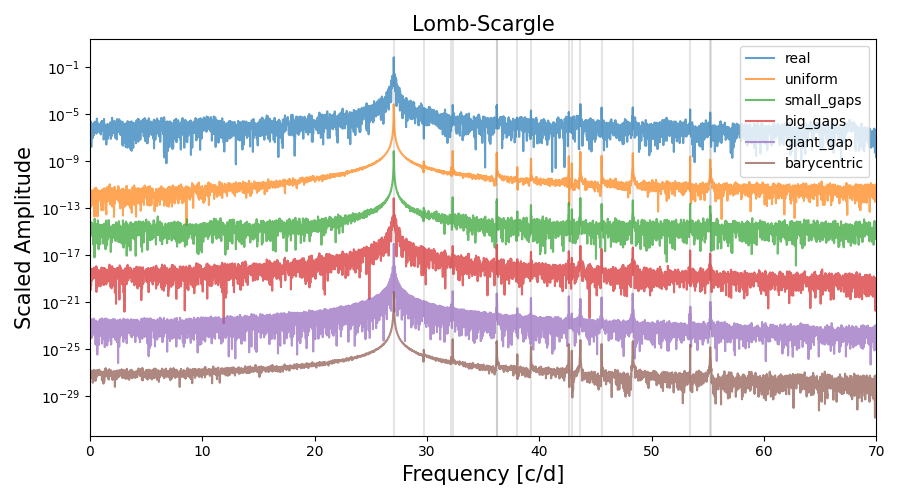

In [17]:
fig, ax = plt.subplots(figsize=figsize)
plt.tight_layout()

for i, key in enumerate(times.keys()):
    ax.plot(fgrid, LS_power[key] / 10000 ** i, alpha=0.7, label=key)

ax.set_xlabel(r'Frequency [c/d]',fontsize = fontsize)
ax.set_ylabel(r'Scaled Amplitude',fontsize = fontsize)

for ff in (np.array(omegas)/(np.pi*2)):
    plt.axvline(ff, alpha = 0.1, color = 'k', zorder = -10)

        
ax.set_xlim(*frequency_xlim)
ax.set_yscale('log')
ax.set_title('Lomb-Scargle', fontsize = fontsize)
plt.legend()
plt.tight_layout()
plt.savefig("LS_with_without_gaps.png")



# Remove the brightest mode and re-Lomb-Scargle??
This section contains way too much code, but we wrote it for something more general.

In [64]:
##### This set of functions does the traditional fitting Hogg loves
def _hogg_design_matrix(fs, ts):
    assert np.all(fs > 0.)
    N = len(ts)
    X = np.ones_like(ts)
    for f in fs:
        X = np.vstack([np.exp(-2.j * np.pi * f * ts), X, np.exp(2.j * np.pi * f * ts)])
    return X.T

def hogg_traditional_fit(ts, ys, fs):
    X = _hogg_design_matrix(fs, ts)
    Zs, _, _, _ = np.linalg.lstsq(X, ys, rcond=1e-9) # MAGIC
    return Zs, X

def WtLSP_init(time, fgrid=None):
    fpeaks = np.array([])
    ppeaks = np.array([])
    
    deltaf = 0.5/(np.max(time) - np.min(time))
    maxf = 0.5 / np.median(time[1:] - time[:-1]) # assumes data are ordered in time
    if fgrid is None:
        fgrid = np.arange(deltaf, maxf, deltaf)
    
    return fpeaks, ppeaks, deltaf, fgrid

def parabola_peak(ys, plot= False):
    """
    ## Notes:
    - Assumes `ys` is shape `(3, )`
    - Assumes data are equally spaced!
    """
    y_minus, y_zero, y_plus = ys
    a0 = y_zero
    a1 = (y_plus - y_minus) / 2
    a2 = y_plus - (2. * y_zero) + y_minus
    x_max = -1. * a1 / a2
    y_max = a0 + a1 * x_max + 0.5 * a2 * x_max * x_max
    
    if plot: 
        fig, ax = plt.subplots()
        #print (a0, a1, a2)
        plt.scatter(np.arange(3) - 1, ys)
        xplot = np.linspace(-1.5,1.5,100)
        
        plt.plot(xplot,a0 + a1 * xplot + 0.5 * a2 * xplot**2, 'r-')
        plt.scatter(x_max, y_max)
        plt.show()
        #plt.scatter(fgrid[maxi - 1: maxi + 2], pgrid[maxi - 1: maxi + 2])
    
    return x_max, y_max

In [19]:
def create_fs_horror(fpeaks, deltaf, Khalf=1): 
    tiny = 1.e-9 # magic 
    foo = np.concatenate([np.arange(f - Khalf * deltaf, f + (Khalf + 0.5) * deltaf, deltaf) for f in fpeaks]) 
    return foo[foo > tiny] 


def WtLSP_step(time, flux, dflux, resid, fps, pps, deltaf, fgrid, i, maxiter, Khalf, flimit = 100000, ax=None): 
        
    pgrid = LombScargle(time, resid).power(fgrid) 
    
    #print ("WtLSP_step(): sum of pgrid: {}".format(np.sum(pgrid))) 

    # find the tallest peak 
    flimit_mask = [fgrid < flimit] # only up to a certain flimit 
    maxi = np.argmax(pgrid[flimit_mask[0]]) 
    
    if maxi == 0: 
        fpeaks = np.append(fps, fgrid[0]) 
        ppeaks = np.append(pps, pgrid[0]) 
    else: 
        dimensionless_shift, p = parabola_peak(pgrid[maxi - 1: maxi + 2], plot = False) 
        fpeaks = np.append(fps, fgrid[maxi] + dimensionless_shift * deltaf) 
        ppeaks = np.append(pps, p) 
    
    fs = create_fs_horror(fpeaks, deltaf, Khalf) 
    Zs, XX = hogg_traditional_fit(time, flux, fs) 
    resid = flux - (XX @ Zs).real 
    
    if ax is not None: 
        # if True:                           # make all plots 
        if (i == 0) or (i == maxiter - 1):   # make only the first and last plot 
            if (i == 0): 
                factor = 5 
                color = 'red' 
            else:
                factor = 1
                color = 'dodgerblue'
                
            WtLSP_plot(ax, fgrid, pgrid * factor, i, color)
        
    return resid, fpeaks, ppeaks

In [20]:
def WtLSP_plot(ax, fgrid, pgrid, i, color):
    
    
    ax.plot(fgrid, pgrid, label = str(i) + " peaks removed", alpha=0.4, color = color) 
    
def WtLSP(time, flux, dflux, Khalf, fgrid=None, maxiter=5):

    fpeaks, ppeaks, deltaf, fgrid = WtLSP_init(time, fgrid)
        
    resid = flux.copy()
    
    fig, ax = plt.subplots(figsize = figsize)
    plt.tight_layout()
    
    for i in range(maxiter):
        
        resid, fpeaks, ppeaks = WtLSP_step(time, flux, dflux, resid, fpeaks, ppeaks,
                                           deltaf, fgrid, i, maxiter, Khalf, ax=ax)
    
    ax.set_yscale('log')

    plt.legend(fontsize = fontsize)
    ax.set_xlabel('')
    ax.set_xlim(*frequency_xlim)

    return resid, fpeaks, ppeaks, ax

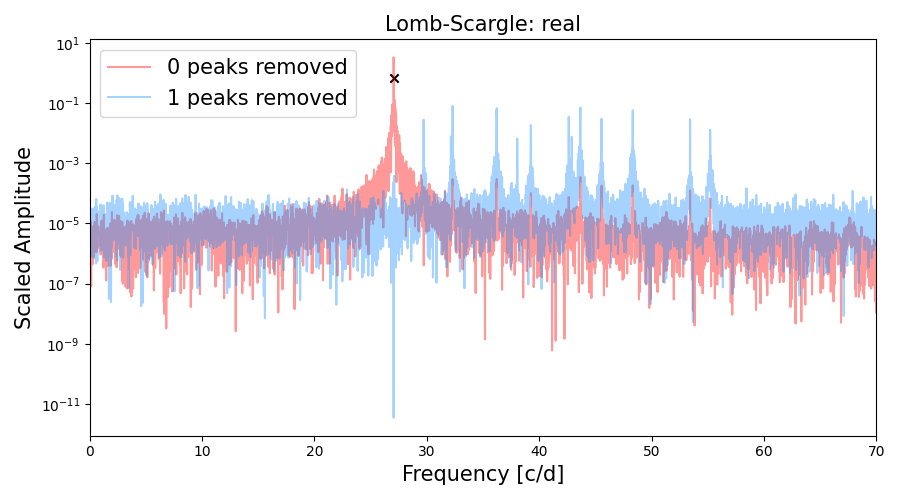

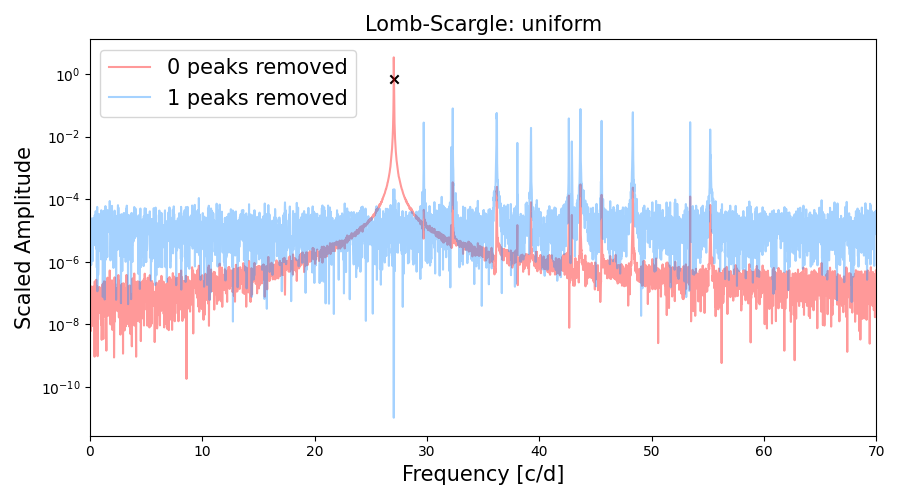

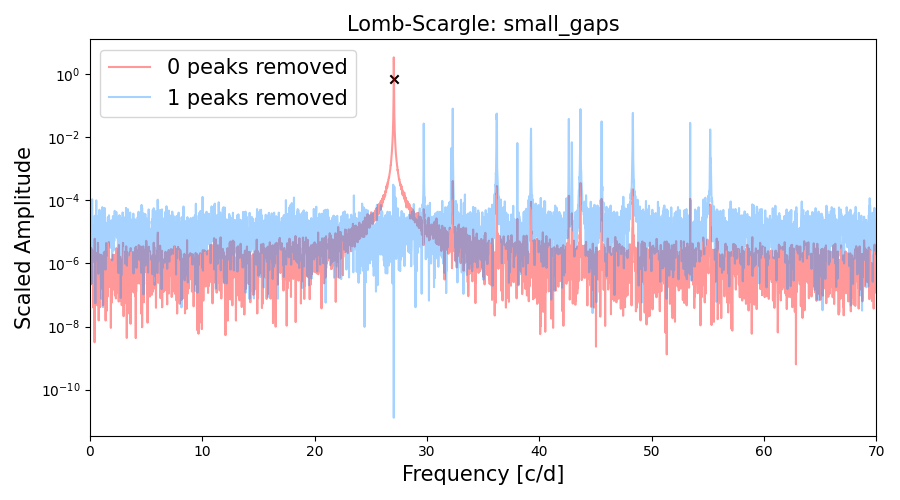

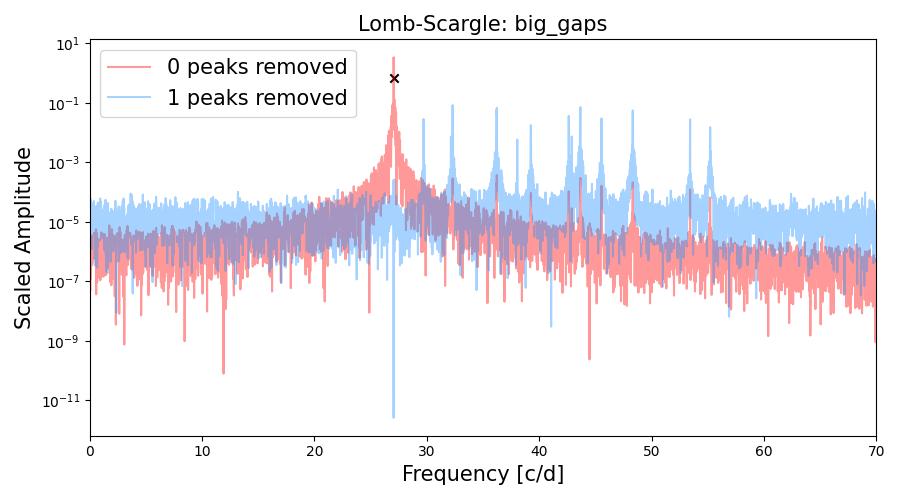

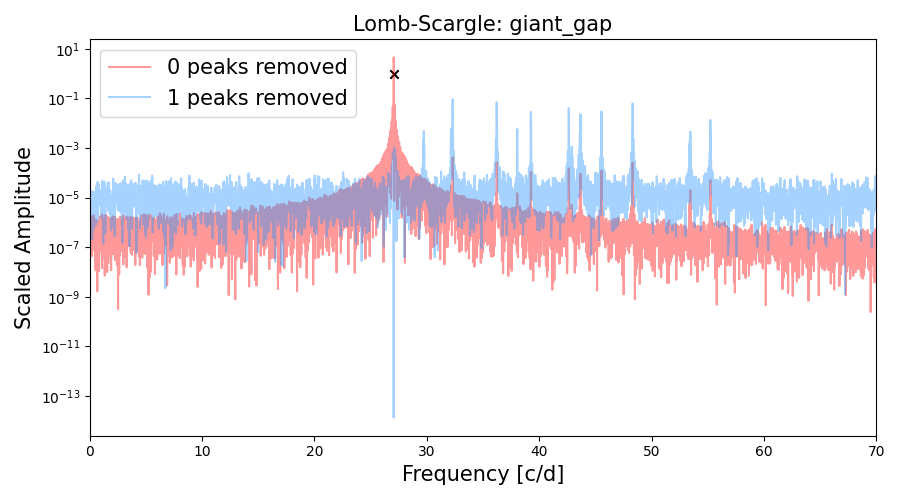

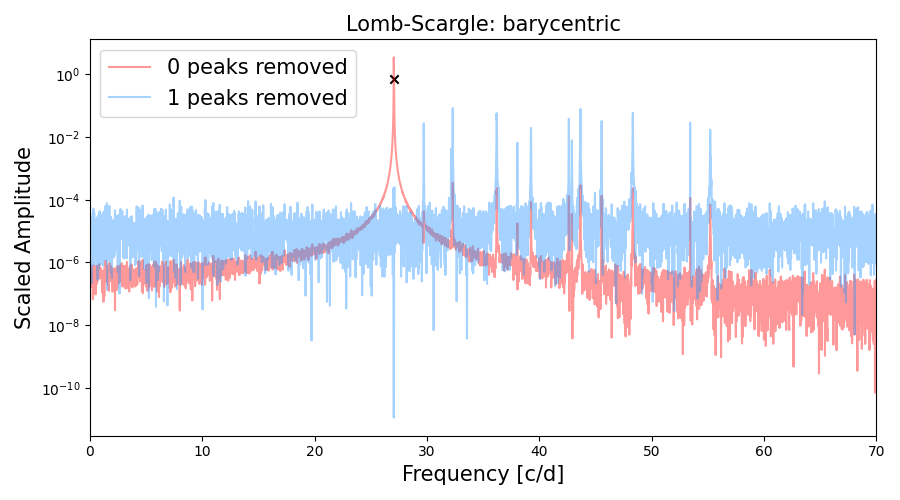

In [21]:
# apply the wtLS to each of the times sampling

for i, key in enumerate(times.keys()):
    
    resid, fpeaks, ppeaks, ax = WtLSP(times[key], fluxes[key], 1e-6*len(fluxes[key]), fgrid=fgrid, Khalf = 3, maxiter=2)
    ax.scatter(fpeaks[0:-1], ppeaks[0:-1], marker = 'x', color = 'k')
    ax.set_xlabel(r'Frequency [c/d]',fontsize = fontsize)
    ax.set_ylabel(r'Scaled Amplitude',fontsize = fontsize)
    ax.set_title('Lomb-Scargle: {}'.format(key), fontsize = fontsize)
    plt.tight_layout()
    plt.show()
    #plt.savefig("LS_wtLS.png")


# Interpolation to a uniform grid??

In [22]:
# interpolate gaps 

#in_gap = np.isnan(times_uniform)
#for gidx in gap_idx: 
#    in_gap = np.logical_or(in_gap, (times_uniform > times_real[gidx]) * (times_uniform < times_real[gidx +1]))

In [23]:
def interpolate_gaps(key, start_times, end_times, interpolate = True, plot= True, LS = True):

    '''
    if interpolate = True: interpolate between the data points -- better for small gaps 
    
    if interpolate = False, fill with a median flux value in between the gaps -- better for big gaps
    '''
    
    in_gap = np.isnan(times['uniform']) # make an array of nans in the shape of the times

    for s,e in zip(start_times, end_times): 
        
        in_gap = np.logical_or(in_gap, (times['uniform'] > s) * (times['uniform'] < e))
        
    if interpolate == True:
        flux_interp = np.interp(times['uniform'], times[key], fluxes[key])
        title  = 'gaps filled with interpolated flux'
    else:
        flux_interp = np.interp(times['uniform'], times[key], fluxes[key])
        flux_interp[in_gap] = np.nanmedian(flux_interp)
        title  = 'gaps filled with overall median flux'
            
    
    # plot
    if plot == True:
        fig, ax = plt.subplots(figsize = figsize)
        plt.tight_layout()
        
        ax.scatter(times_uniform, flux_interp, color = 'k', s = 2, label="interpolated")
        ax.scatter(times[key], fluxes[key], color='darkorange', s = 2, label=key)
        plt.tight_layout()
        plt.xlabel("Time", fontsize = fontsize)
        plt.ylabel("Normalized Flux", fontsize = fontsize)
        plt.legend(fontsize = fontsize)
        plt.show()
        
    if LS == True:
        
        LS_power_interp = LombScargle(times['uniform'], flux_interp).power(fgrid)
        LS_power = LombScargle(times[key], fluxes[key]).power(fgrid)
        
        fig, ax = plt.subplots(figsize=figsize)
        plt.tight_layout()
        
        ax.plot(fgrid, LS_power_interp,'green',alpha=0.4, label = key + ' interpolated to regular grid (offset)')
        ax.plot(fgrid, LS_power / 1000,'r',alpha=0.3, label = key)
        
        ax.set_xlabel(r'Frequency [c/d]',fontsize = fontsize)
        ax.set_ylabel(r'Scaled Amplitude',fontsize = fontsize)
        
        ax.set_xlim(*frequency_xlim)
        ax.set_yscale('log')
        ax.set_title('Lomb-Scargle: ' + title, fontsize = fontsize)
        plt.legend()
        plt.tight_layout()
        #plt.savefig("LS_interpolated_data.png")

    return times_uniform, flux_interp

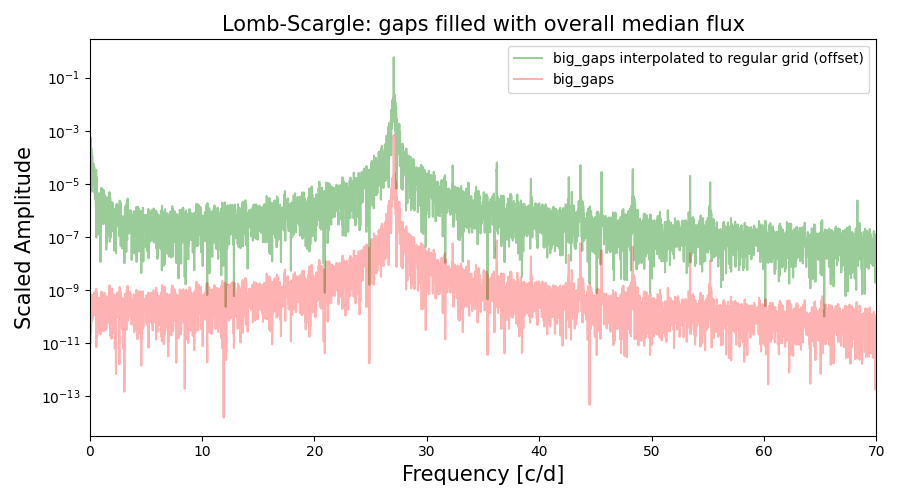

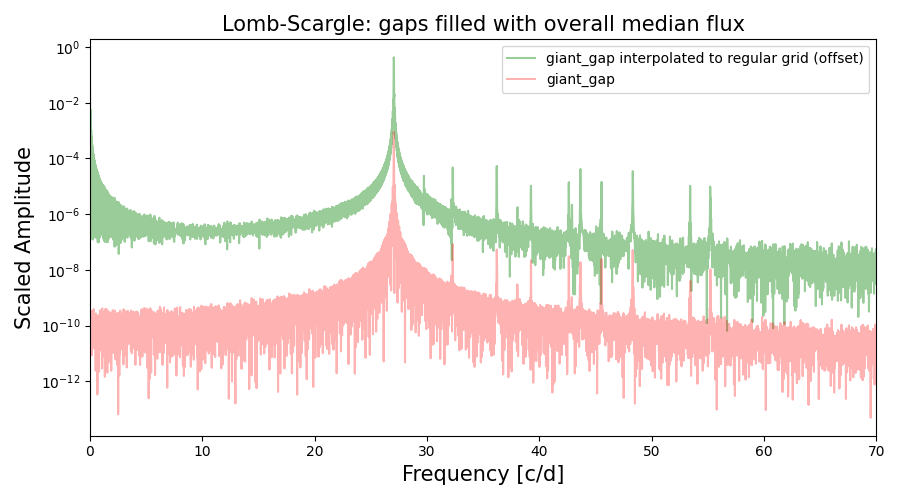

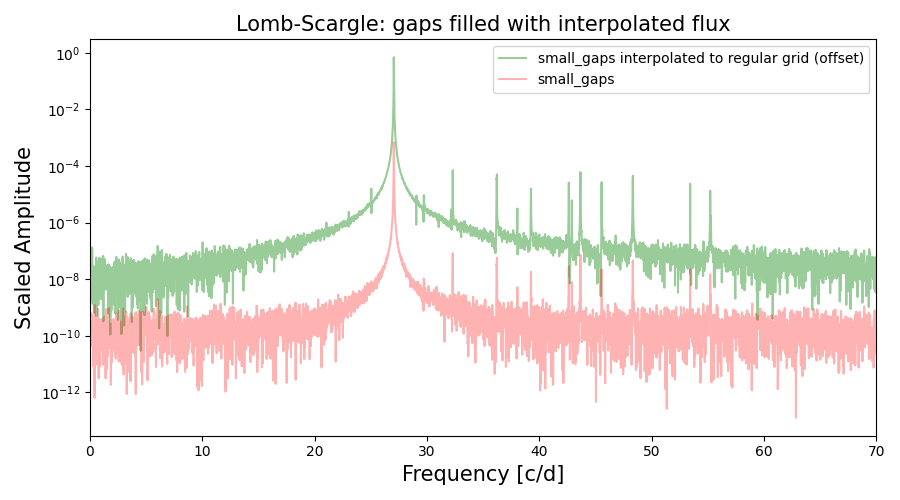

In [24]:
interpolate_gaps('big_gaps', gap_start_times, gap_end_times, interpolate = False, plot= False)

interpolate_gaps('giant_gap', giant_gap_start_times, giant_gap_end_times, interpolate = False, plot= False)

times_interp_small_gap, flux_interp_small_gap =  interpolate_gaps('small_gaps', small_gap_start_times, small_gap_end_times, interpolate = True,  plot= False)


# Run LS on each contiguous chunk and combine?
Big question: **Is adding these correct??**
Try: median combine? 

In [25]:
# Find the chunks

def run_on_chunks(key, start_times, end_times, plot_frequencies = False):
    
    power_chunk = []

    for s,e in zip(start_times, chunk_end_times):
        in_chunk  = (times[key] > s) *  (times[key] < e) 
        
        power_chunk.append(LombScargle(times[key][in_chunk], fluxes[key][in_chunk]).power(fgrid))

    
    power_full = LombScargle(times[key], fluxes[key]).power(fgrid)
    
    power_chunk = np.array(power_chunk)
    
    fig, ax = plt.subplots(figsize = figsize)
    plt.tight_layout()
    
    ax.plot(fgrid, power_full,'k',alpha=0.3, label = 'full {}'.format(key))
    
    for i, amp in enumerate(power_chunk):
        ax.plot(fgrid, amp / 10000 ** (i + 1), alpha=0.3, label = 'chunk {} (offset)'.format(i+1))
    
    if plot_frequencies == True:
        for ff in (np.array(omegas)/(np.pi*2)):
            
            plt.axvline(ff, alpha = 0.1, color = 'k', zorder = -10)
        
    plt.xlabel('Freq (Hz)')
    ax.set_xlim(*frequency_xlim)
    ax.set_yscale('log')
    plt.legend()
   

    fig, ax = plt.subplots(figsize = figsize)
    plt.tight_layout()
        
    ax.plot(fgrid, power_full,'k',alpha=0.3, label = 'full {}'.format(key))
    ax.plot(fgrid, np.sum(power_chunk, axis=0) * 100, alpha=0.3, label = 'sum of chunks (offset)'.format(i+1))

    if plot_frequencies == True:
        for ff in (np.array(omegas)/(np.pi*2)):
            
            plt.axvline(ff, alpha = 0.1, color = 'k', zorder = -10)
        
    plt.xlabel('Freq (Hz)')
    ax.set_xlim(*frequency_xlim)
    ax.set_yscale('log')
    plt.legend()

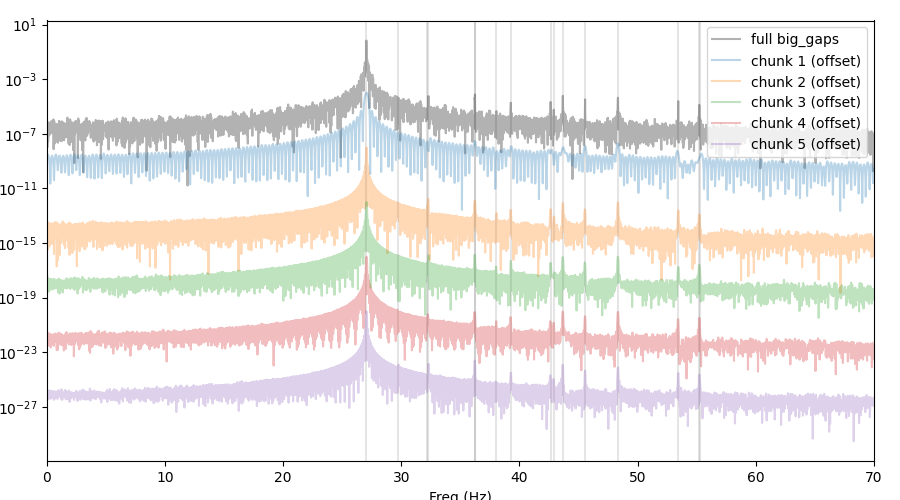

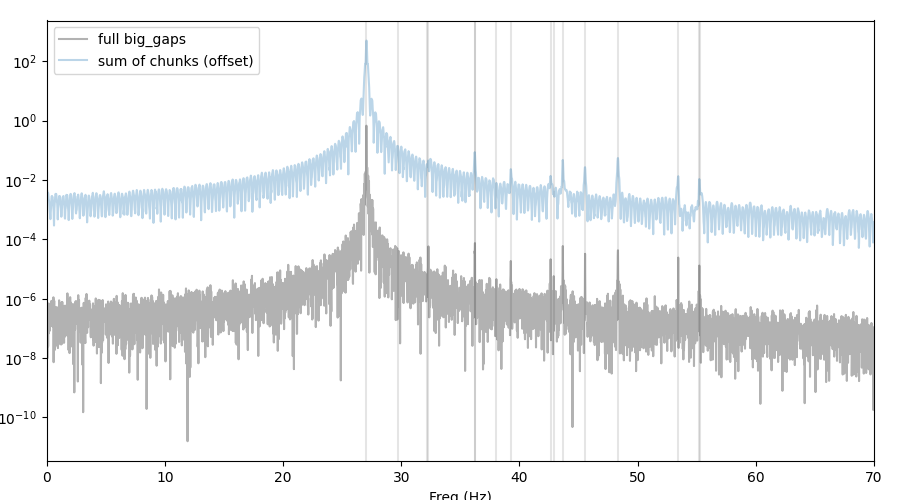

In [26]:
run_on_chunks('big_gaps', chunk_start_times, chunk_end_times, plot_frequencies = True)

# What about the Fourier Transform of no-gaps and interpolated?

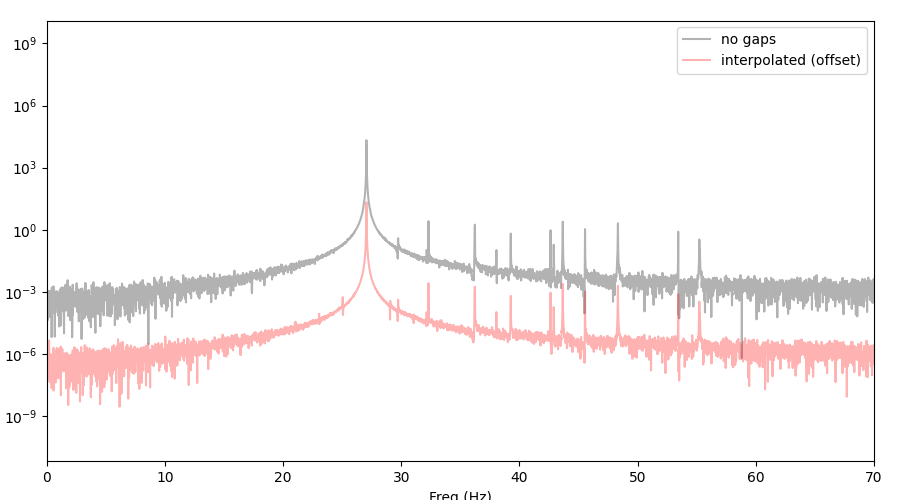

In [27]:
X_uniform = fft(fluxes['uniform'])
X_interp = fft(flux_interp_small_gap)

N = len(X_uniform)
T = (np.max(times['uniform']) - np.min(times['uniform'])) * N/(N-1)
fft_freqs = np.arange(N)/T 

fig, ax = plt.subplots(figsize = figsize)
plt.tight_layout()

plt.plot(fft_freqs, np.abs(X_uniform) ** 2, 'k-', label = 'no gaps', alpha=0.3)
plt.plot(fft_freqs, np.abs(X_interp) ** 2/1000, 'r-', label = 'interpolated (offset)', alpha=0.3)

plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

ax.set_xlim(*frequency_xlim)
ax.set_yscale('log')
plt.legend()

# The Fourier Series method - this doesn't work at the moment (might not work at all)

#### next for this method: put a more sensible regularization on the fourier series


In [28]:
def design_matrix(ts, fgrid):
    """
    Note the non-trivial ordering of the functions.
    """
    omegas = 2. * np.pi * fgrid
    X = np.ones((len(ts), 2 * len(fgrid) - 1))
    X[:,1::2] = np.sin(omegas[None, 1:] * ts[:, None])
    X[:,2::2] = np.cos(omegas[None, 1:] * ts[:, None]) # I'm dyin heah
    print("design_matrix(): made", X.shape)
    return X

def something_other_than_traditional_fit(ts, ys, fgrid, rcond):
    X = design_matrix(ts, fgrid)
    Zs, A, B, C = np.linalg.lstsq(X, ys, rcond=rcond) # MAGIC
    #print (A, B, C)
    return Zs, X

def power(Zs):
    ps = Zs[1::2] ** 2 + Zs[2::2] ** 2
    return np.concatenate([[Zs[0] ** 2, ], ps])

In [29]:
# just do zero frequency and the injected frequencies
fgrid_very_small = np.array(omegas) / (2. * np.pi)
fgrid_very_small = np.concatenate([[0.,], fgrid_very_small])
amps_very_small, X_very_small = something_other_than_traditional_fit(times['real'], fluxes['real'], fgrid_very_small, None)

design_matrix(): made (37201, 33)


In [30]:
# just do frequencies near zero and the injected frequencies
include = fgrid == 0
epsilon = 0.5
for f in fgrid_very_small:
    include = np.logical_or(include, np.abs(fgrid-f) < epsilon)
fgrid_small = fgrid[include]

In [31]:
def plot_FS_(name):

    fig, ax = plt.subplots(3,1, figsize=figsize)
    plt.tight_layout()
    
    ax[0].set_title("rcond:" + name)
    ax[0].plot(fgrid_small, power(amps_small), 'k-')
    ax[1].plot(fgrid_small, amps_small[::2], 'r-')
    ax[2].plot(fgrid_small[1:], amps_small[1::2], 'b-')
    
    ax[0].set_yscale('log')
    
    #ax[0].axvline()
    
    plt.show()
    
    
# for rc in np.arange(0.2, 0.6, 0.05):
    
#     amps_small, X_small = something_other_than_traditional_fit(times['real'], fluxes['real'] - 1., fgrid_small, rcond = rc)

#     plot_FS_(str(rc))

# Add granualtion to model with Celerite

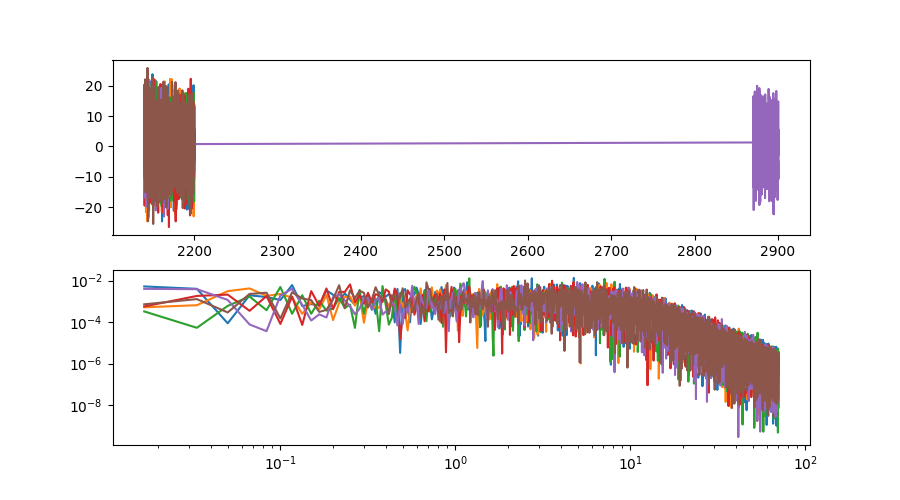

In [32]:
fig, ax = plt.subplots(2, 1, figsize = figsize)

S0 = 1
w0 = 2*np.pi/0.1

for i, key in enumerate(times.keys()):
    t = times[key]
    kernel = terms.SHOTerm(S0=S0, w0=w0, Q=1/np.sqrt(2))
    gp = GaussianProcess(kernel, t)
    y_granulation = gp.sample()
    
    
    ax[0].plot(t, y_granulation)

    # take the lomb-scargle of the granulations
    
    LS_power = LombScargle(t, y_granulation).power(fgrid)
    
    ax[1].loglog(fgrid, LS_power)    
    




# Implementing the Welch FT

In [33]:
def sort_lists(list1, list2):
    '''
    Sort according to list 1
    '''
    # Use zip to combine the two lists element-wise
    combined_lists = zip(list1, list2)

    # Sort the combined lists based on the elements of list1
    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0])

    # Unpack the sorted lists
    sorted_list1, sorted_list2 = zip(*sorted_combined_lists)

    return list(sorted_list1), list(sorted_list2)


In [34]:
def identify_gaps(times, small_gap_size):
    
    dts = np.diff(times)
    
    big = small_gap_size * np.nanmedian(dts)
    
    small = 1.5 * np.nanmedian(dts)
    
    big_gap_idx = np.where(dts > big)[0]

    small_gap_indx = np.where((dts > small) * (dts < big))[0]
    
    gap_start_times = list(times[big_gap_idx])
    gap_end_times =   list(times[big_gap_idx + 1])
    
    chunk_start_times = np.array([np.nanmin(times)] + gap_end_times)
    chunk_end_times = np.array(gap_start_times + [np.nanmax(times)])

    small_gap_start_times = list(times[small_gap_indx])
    small_gap_end_times =   list(times[small_gap_indx + 1])
    
    print ("- - - - - ")
    print ("number of big gaps: {}".format(len(gap_start_times)))
    print ("number of small gaps: {}".format(len(small_gap_start_times)))
    print ("- - - - - ")
    print ()
    return gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, np.nanmedian(dts)


In [35]:
def interpolate_small_gaps(time_array, flux_array, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False):

    in_gap_time_list = []
    in_gap_flux_list = []

    # make sure that the lists are sorted in time - otherwise we can't interpolate - for some reason this is not always the case
    time_array, flux_array = sort_lists(time_array, flux_array) # sort according to list 1

    for start,end in tqdm(zip(small_gap_start_times, small_gap_end_times)):

        # create a cut out around the small gap - this will be used to interpolate the data and to then fill in the gap with the interpolated data
        
        gap_window = (time_array > (start - interpolate_window)) * (time_array < (end + interpolate_window))
        
        # Create a PchipInterpolator object
        pchip_interpolator = PchipInterpolator(time_array, flux_array, extrapolate =False)
        
        # create grid to interpolate onto - this it the missing data points
        times_in_gap = np.arange(start + cadence, end, cadence)
        
        # interpolate the data
        flux_in_gap = pchip_interpolator(times_in_gap)
        
        in_gap_time_list.append(times_in_gap)
        in_gap_flux_list.append(flux_in_gap)
        
    # add the original data
    in_gap_time_list.append(time_array)
    in_gap_flux_list.append(flux_array)

    times_interpolated_small = np.hstack(in_gap_time_list)
    fluxes_interpolated_small = np.hstack(in_gap_flux_list)

    times_interpolated_small, fluxes_interpolated_small = sort_lists(times_interpolated_small, fluxes_interpolated_small) # sort according to list 1

    if plot == True:
        # check that the small gaps have gone and that the big gaps are still there
        fig, ax = plt.subplots(figsize = figsize)

        plt.scatter(times_interpolated_small, np.zeros_like(fluxes_interpolated_small), s = 10)

        for s,e in zip(chunk_start_times, chunk_end_times):
            ax.axvspan(s, e, alpha=.05, color='navy')

        plt.show()

    return times_interpolated_small, fluxes_interpolated_small


In [36]:
# define the minimum chunk size that will be used for Welch

def which_chunks(times, fluxes, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False):
    
    '''
    Function to determine which of the large chunks should be used for Welch.
    '''
    
    # first, make arrays of the flux, time for each chunk of data that is larger than the minimum chunk size
    chunks_times = []
    chunks_fluxes = []
    used_chunk_sizes = []

    if plot_chunks == True:
        fig, ax = plt.subplots(figsize = figsize)
        plt.scatter(times, np.zeros_like(fluxes), s = 10)

    for start_chunk,end_chunk in zip(chunk_start_times, chunk_end_times):
        
        chunk_size = end_chunk - start_chunk # chunk size in days
        
        if (chunk_size) > min_welch_chunk: # if yes, then we can use it
            in_chunk = (times > start_chunk) * (times < end_chunk)
            
            chunks_times.append(np.array(times)[in_chunk])
            chunks_fluxes.append(np.array(fluxes)[in_chunk])
            used_chunk_sizes.append(chunk_size)

            if plot_chunks:
                ax.axvspan(start_chunk, end_chunk, alpha=.05, color='maroon')
            
            if extra_info:
                print ("used chunk: {} days".format(chunk_size))
        else: 
            if extra_info:
                print ("chunk too small with length: {} days   (not used)".format(chunk_size))
    
    if plot_chunks:
        plt.show()
    
    print ()
    print ("- - - - - ")
    print ("number of discarded chunks: {}".format(len(chunk_start_times) - len(chunks_times)))
    print ("number of used chunks: {}".format(len(chunks_times)))
    print ("- - - - - ")
    
    return chunks_times, chunks_fluxes, used_chunk_sizes


def welch(times, fluxes, chunks_times, chunks_fluxes, segment_size, fgrid, plot_log = [True, True], extra_info = False, plot_chunks = False, plot_results = True, plot_welch_comparison = False, injected_omegas = None, known_frequencies = None):
    
    '''
    function to run Welch on the individual chunks of data and median combine it together
    times: time array
    fluxes: flux array
    chunk_start_times: start times of the chunks
    chunk_end_times: end times of the chunks
    min_welch_chunk: minimum chunk size in days
    segment_size: size of the segments in days
    frgid: frequency grid (only needed if the plot_welch_comparison is True - needed for the LS comparison)
    plot_chunks: if True plot the chunks of data that are used for Welch
    plot_results: if True plot the results of the Welch
    plot_welch_comparison: if True plot the Welch results and compare to the LS
    injected_omegas: if not None, plot the injected frequencies on the Welch plot
    '''


    # now run welch on each chunk 
    
    # we now have the chunks of data (where the small gaps have been interpolated) that we will use for Welch
    if plot_results:
        fig, ax = plt.subplots(figsize = figsize)

    fs_welch_list = []
    psd_welch_list = []

    sampling_frequency = 1/(np.nanmedian(np.diff(times))) # for 2 minute cadence data this is 720 d-1
    nperseg = int(segment_size * sampling_frequency)
    
    for time, flux in zip(chunks_times, chunks_fluxes):

        fs, psd = ss.welch(flux, fs=sampling_frequency, nperseg = nperseg, average = 'median')
        
        fs_welch_list.append(fs)
        psd_welch_list.append(psd)

        if plot_results:
            plt.plot(fs, psd, alpha = 0.4)

    fs_welch_median = np.median(np.array(fs_welch_list), axis = 0) 
    psd_welch_median = np.median(np.array(psd_welch_list), axis = 0) 
    psd_welch_summed = np.sum(np.array(psd_welch_list), axis = 0)  

    if injected_omegas is not None:
        for ff in (np.array(injected_omegas)/(np.pi*2)):
            plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)

    if known_frequencies is not None:
        for ff in (np.array(known_frequencies)):
            plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)
            
    if plot_results:
        plt.plot(fs_welch_median, psd_welch_median, color = 'k', label = 'welch - median combined', zorder = 10)
        plt.plot(fs_welch_median, psd_welch_summed/len(chunks_fluxes), color = 'red', label = 'welch - summed')
        plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
        plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
        if plot_log[0] == True:
            plt.loglog()
        else:
            plt.yscale('log')

        
    if plot_welch_comparison:
        
        fig, ax = plt.subplots(figsize = figsize)

        # fs is the sampling frequency (in Hz) and nperseg is the number of samples per segment
        fs8_all_data, psd8_all_data = ss.welch(fluxes, fs=sampling_frequency, nperseg=nperseg)
        
        if injected_omegas is not None:
            for ff in (np.array(injected_omegas)/(np.pi*2)):
                plt.axvline(ff, alpha = 0.1, color = 'darkorange', zorder = -10)

        if known_frequencies is not None:
            for ff in (np.array(known_frequencies)):
                plt.axvline(ff, alpha = 0.2, color = 'darkorange', zorder = -10)
                #plt.axvline(ff/2, alpha = 0.1, color = 'k', zorder = -10)
        
        LS_power = LombScargle(times, fluxes).power(fgrid)
        
        plt.plot(fs_welch_median, psd_welch_median, color = 'k', label = 'Welch in chunks - median combined', zorder = 10)
        plt.plot(fs_welch_median, psd_welch_summed/len(chunks_fluxes), color = 'red', label = 'Welch in chunks - summed')
        plt.plot(fs8_all_data, psd8_all_data, label = 'Welch on all data (small-gap-interpolated)')
        plt.plot(fgrid, LS_power / 100000,'k',alpha=0.3, label = 'Lomb-Scargle on all data (small-gap-interpolated)')
        
        plt.xlabel(r'$f$ ($\mathrm{Hz}$)')
        plt.ylabel(r'$P(f)$ ($\mathrm{Hz}^{-1}$)')
  
        if plot_log[1] == True:
            plt.loglog()
        else:
            plt.yscale('log')

        plt.legend(loc= 2)        
        plt.xlim(0.1, fgrid[-1])
    

    return fs_welch_median, psd_welch_median

In [37]:
def run_full_welch(time, flux, small_gap_size, interpolate_window, min_welch_chunk, segment_size, fgrid, plot_log = [True, True], extra_info = False, plot_chunks = False, plot_welch_comparison = False, injected_omegas = None, known_frequencies = None):
    
    '''
    function to run Welch on the individual chunks of data and median combine it together
    times: time array
    fluxes: flux array
    chunk_start_times: start times of the chunks
    chunk_end_times: end times of the chunks
    min_welch_chunk: minimum chunk size in days
    segment_size: size of the segments in days
    frgid: frequency grid (only needed if the plot_welch_comparison is True - needed for the LS comparison)
    plot_chunks: if True plot the chunks of data that are used for Welch
    plot_results: if True plot the results of the Welch
    plot_welch_comparison: if True plot the Welch results and compare to the LS
    injected_omegas: if not None, plot the injected frequencies on the Welch plot
    '''

    # first, identify the gaps in the data
    gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time, small_gap_size)

    # interpolate the small gaps
    times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time, flux, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)

    # now, run Welch on the chunks of data
    chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = plot_chunks, extra_info = False)

    print (used_chunk_sizes)
    
    fs_welch_median, psd_welch_median  = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid, plot_log = plot_log, extra_info = False, plot_chunks = plot_chunks, plot_results = True, plot_welch_comparison = plot_welch_comparison, injected_omegas = injected_omegas, known_frequencies = known_frequencies)

    return fs_welch_median, psd_welch_median, used_chunk_sizes
    
    

- - - - - 
number of big gaps: 13
number of small gaps: 119
- - - - - 



119it [00:00, 231.45it/s]



- - - - - 
number of discarded chunks: 8
number of used chunks: 6
- - - - - 
[6.402772666499004, 6.524968280597022, 6.534691058424414, 6.448532254462862, 6.534648181802822, 6.506846677973044]


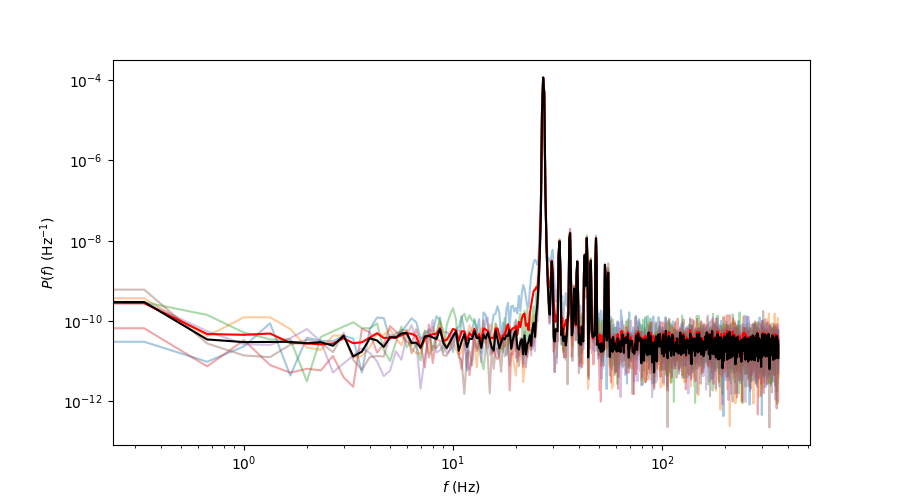

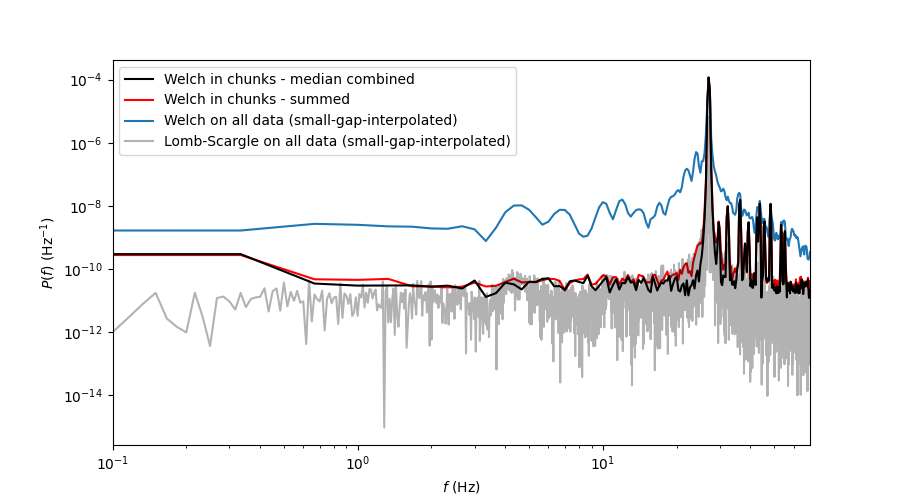

In [48]:
# toggles 

small_gap_size = 7 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.5 # days
min_welch_chunk = 6 # days  
segment_size = 3 # days

# use the simulated data
times_real = times['real']
flux_real = fluxes['real']

fs_welch_median, psd_welch_median, used_chunk_sizes = run_full_welch(times_real, flux_real, small_gap_size, interpolate_window, min_welch_chunk, segment_size, fgrid, plot_log = [True, True], extra_info = False, plot_chunks = False, plot_welch_comparison = True, injected_omegas = None, known_frequencies = None)




In [116]:
def snr_peaks(fs, psd, signal_limits, window_limits, plot = True, method = 'median'):

    signal_lower, signal_upper = signal_limits
    window_lower, window_upper = window_limits    

    #psd = psd/np.median(psd)
    if plot:
        fig, ax = plt.subplots()

        plt.plot(fs, psd, color = 'k')

        plt.axvline(signal_lower)
        plt.axvline(signal_upper)

    deltaf = np.median(np.diff(fs))
    
    # cut out an area - we're going to look at the highest in this region 
    flimit_mask = [(fs > signal_lower) * fs < signal_upper] # only up to a certain flimit

    # find the peak
    maxi = np.argmax(psd[flimit_mask[0]])

    if plot:
        plt.axvline(fs_welch_median[maxi], color = 'orange', zorder = -10)
        
    # use the peak finding function to find the peak    
    dimensionless_shift, ppeaks = parabola_peak(psd_welch_median[maxi - 1: maxi + 2], plot = False)

    fpeaks = fs_welch_median[maxi] + dimensionless_shift * deltaf
    
    if plot:
        plt.axvline(fpeaks, color = 'grey')

    
    # calcaulte the MAD power in a window outsid of where the peaks are
    window_mask =  flimit_mask = [(fs > window_lower) * fs < window_upper] # only up to a certain flimit

    if plot:
        plt.axvline(window_lower, color = 'red')
        plt.axvline(window_upper, color = 'red')
        plt.loglog()
        plt.show()
    
    if method == 'median':
        bkg_ = np.median(fs[window_mask])
    elif method == 'mad':    
        bkg_ =  st.median_abs_deviation(fs[window_mask])
    if method == 'mean':
        bkg_ = np.mean(fs[window_mask])    
    if method == 'std':
        bkg_ = np.std(fs[window_mask])    
        
    snr_peak = ppeaks/bkg_
    
    print ("SNR of peak at f = {}   :   {}    (method: {})".format(fpeaks, snr_peak, method))
    
    return snr_peak

_ = snr_peaks(fs_welch_median, psd_welch_median, signal_limits = [22, 60], window_limits = [62,150],  plot = False, method = 'median')
_ = snr_peaks(fs_welch_median, psd_welch_median, signal_limits = [22, 60], window_limits = [62,150],  plot = False, method = 'mad') 

SNR of peak at f = 27.030047205917693   :   1.5550741932912735e-06    (method: median)
SNR of peak at f = 27.030047205917693   :   3.103236945723474e-06    (method: mad)


In [ ]:
def calculate_snr_peak(periodogram, peak_frequency, peak_window = 0.2, background_window = 0.5, plot = False):
    """
    Calculate the signal-to-noise ratio (SNR) of a peak in a periodogram.
    
    Parameters:
    - periodogram: array-like, the periodogram values
    - peak_frequency: float, the frequency of the peak
    
    Returns:
    - snr: float, the signal-to-noise ratio
    """
    
    peak_index = np.argmin(np.abs(periodogram - peak_frequency))
    
    peak_value = periodogram[peak_index]
    noise_values = np.concatenate((periodogram[:peak_index], periodogram[peak_index+1:]))
    noise_mean = np.mean(noise_values)
    noise_std = np.std(noise_values)
    snr = (peak_value - noise_mean) / noise_std
    return snr


[]

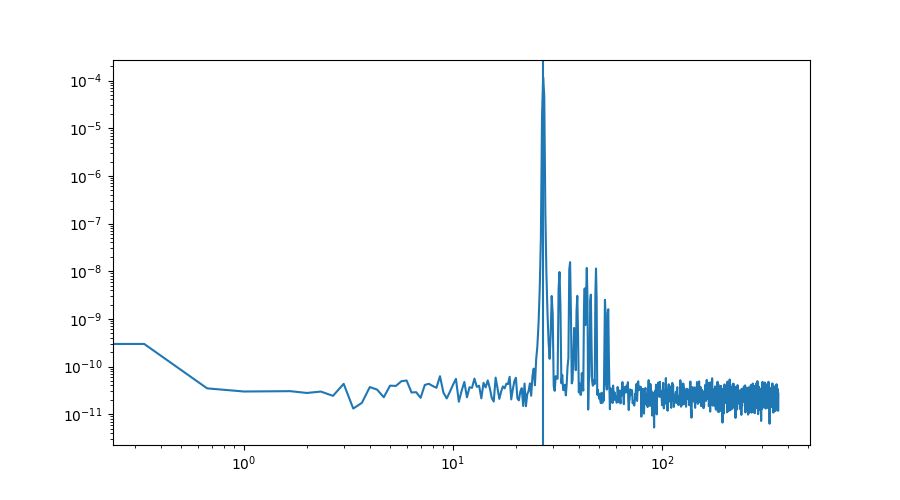

In [ ]:
fig, ax = plt.subplots(figsize = figsize)
plt.plot(fs_welch_median, psd_welch_median)

max_power_index = np.argmax(psd_welch_median)
frequency_at_max_power = fs_welch_median[max_power_index]

plt.axvline(frequency_at_max_power)
plt.loglog()

# Try with real data - Kepler (KIC 10963065)

In [ ]:
# download a kepler lighkurve for a known solar-like oscillator
# NOTE: 1 cycle per day is 11.57 microhertz

lc_kepler = lk.search_lightcurve('KIC 10963065',
                                     cadence='short',
                                     author='Kepler',
                                     quarter=(2,5)).download_all().stitch()

time_kepler = lc_kepler.time.value
flux_kepler = lc_kepler.flux.value

finite = np.isfinite(flux_kepler) * np.isfinite(time_kepler)

time_kepler = time_kepler[finite]
flux_kepler = flux_kepler[finite]

# get the frequency grid
frequency_xlim = [0., 400] # these units are in cycles per day
fgrid_kepler = get_fgrid(time_kepler, 1., frequency_xlim)


In [ ]:
# main toggles 
small_gap_size = 20 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.3 # days

# step number one: identify big and small gaps
gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time_kepler, small_gap_size)

# step number two: interpolate the small gaps
times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time_kepler, flux_kepler, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)



- - - - - 
number of big gaps: 5
number of small gaps: 57
- - - - - 



57it [00:01, 28.75it/s]



- - - - - 
number of discarded chunks: 1
number of used chunks: 5
- - - - - 
[14.792988341490855, 9.207169583394716, 31.5293393653119, 27.626441313252144, 33.57257817364007]


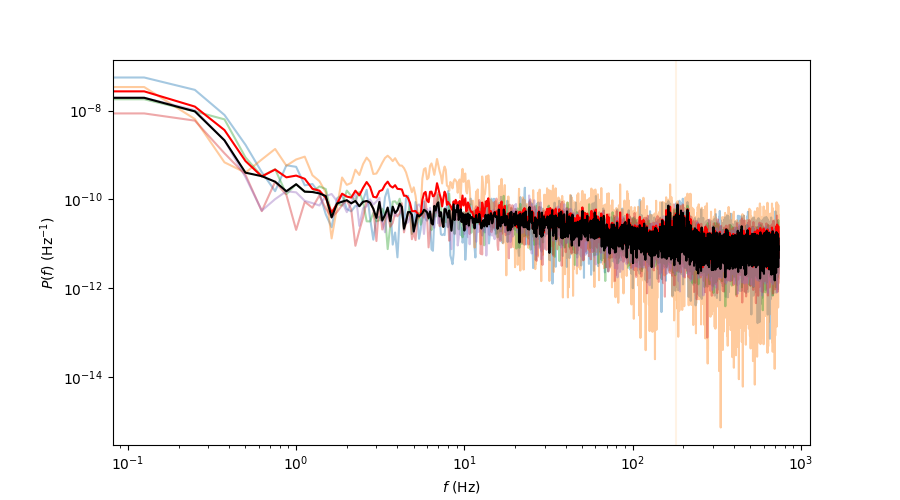

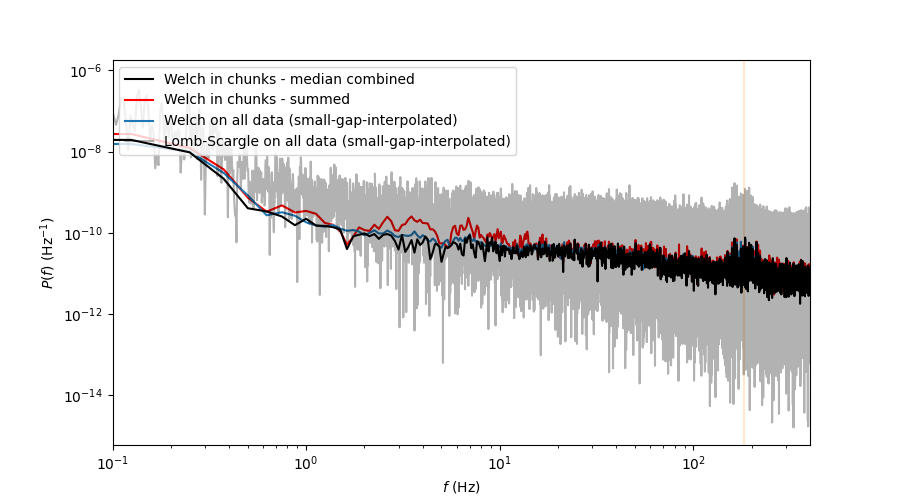

In [ ]:
min_welch_chunk = 9 # days  
segment_size = 8 # days

# determine the chunks that we want to use and their sizes - the size of the chunks will help inform the segment size for Welch
chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False)

print (used_chunk_sizes)

# now, run Welch on the chunks of data
_, _ = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_kepler, extra_info = True, plot_chunks = False, plot_results = True, plot_welch_comparison = True, known_frequencies = [(2100/11.57)], plot_log = [True, True])



##### for the kepler example, see how changing the segment size and welch chunk size affects the recovery of the peaks


- - - - - 
number of discarded chunks: 1
number of used chunks: 5
- - - - - 


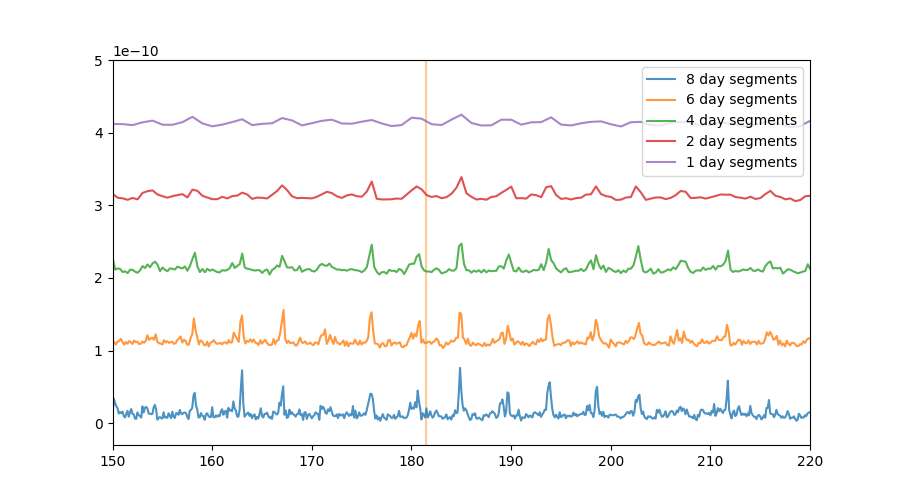

In [ ]:
# investigate how the welch changes with the segment size

min_welch_chunk = 9 # days  
segment_size = 8 # days


fig, ax = plt.subplots(figsize = figsize)

# keep the chunk sizes the same
chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False)

for i,segment_size in enumerate([8,6,4,2,1]):

    fs_welch_median, psd_welch_median = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_kepler, extra_info = False, plot_chunks = False, plot_results = False, plot_welch_comparison = False, known_frequencies = [(2100/11.57)], plot_log = [True, True])
    
    plt.plot(fs_welch_median , psd_welch_median + (i * 1e-10), label = '{} day segments'.format(segment_size), alpha = 0.8)

plt.xlim(150,220)
plt.ylim(-3e-11, 5e-10)
plt.legend()
plt.show()



- - - - - 
number of discarded chunks: 4
number of used chunks: 2
- - - - - 


ValueError: not enough values to unpack (expected 3, got 2)

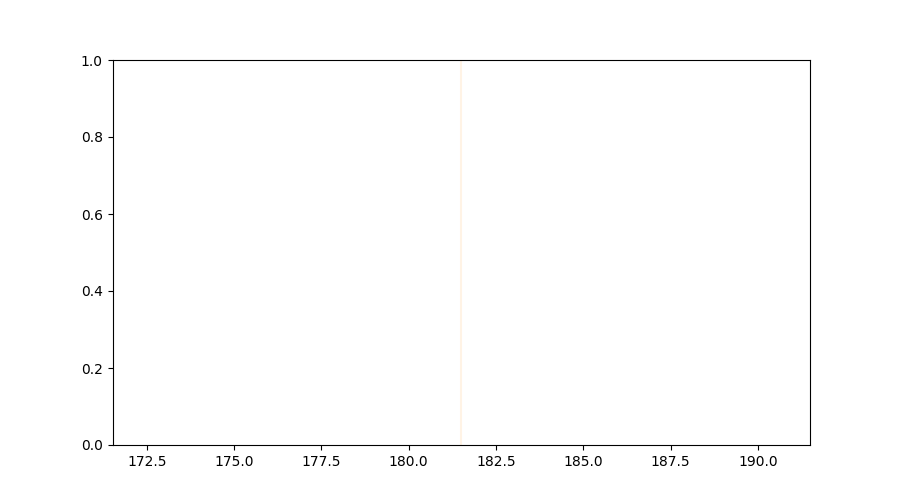

In [ ]:
# investigate how the welch changes min_welch_chunk

fig, ax = plt.subplots(figsize = figsize)

# keep the chunk sizes the same

min_welch_chunks = [30, 20, 10, 8, 5]

for i,min_welch_chunk in enumerate(min_welch_chunks):
    
    chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False)

    segment_size = np.min(used_chunk_sizes)
    
    fs_welch_median, psd_welch_median, used_chunk_sizes = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_kepler, extra_info = False, plot_chunks = False, plot_results = False, plot_welch_comparison = False, known_frequencies = [(2100/11.57)], plot_log = [True, True])
    
    plt.plot(fs_welch_median , psd_welch_median + (i * 1e-10), label = '{} day min chunk'.format(min_welch_chunk), alpha = 0.8)

plt.xlim(150,220)
plt.ylim(-3e-11, len(min_welch_chunks) * 1e-10)
plt.legend()
plt.show()


# TESS (TIC 265488188)

In [ ]:
tic_id = 265488188

# make a lightkurve object
lc = lk.search_lightcurve('TIC {}'.format(tic_id), author = 'SPOC', exptime = 20).download_all().stitch()

time_tess = lc.time.value
flux_tess = lc.flux.value

finite = np.isfinite(flux_tess) * np.isfinite(time_tess)

time_tess = time_tess[finite]
flux_tess = flux_tess[finite]

frequency_xlim = [0., 400] # these units are in cycles per day
fgrid_tess = get_fgrid(time_tess, 1., frequency_xlim)


# LS_power = LombScargle(time_tess, flux_tess).power(fgrid_tess)
# fig, ax = plt.subplots(figsize=figsize)
# plt.plot(fgrid_tess, LS_power)
# plt.tight_layout()
# plt.xlabel(r'Frequency [c/d]',fontsize = fontsize)
# plt.axvline(2693/11.57, color = 'k', alpha = 0.1)
# plt.tight_layout()
# plt.loglog()

In [ ]:
used_chunk_sizes

[14.792988341490855,
 9.207169583394716,
 31.5293393653119,
 27.626441313252144,
 33.57257817364007]

- - - - - 
number of big gaps: 3
number of small gaps: 239
- - - - - 



239it [00:08, 26.67it/s]


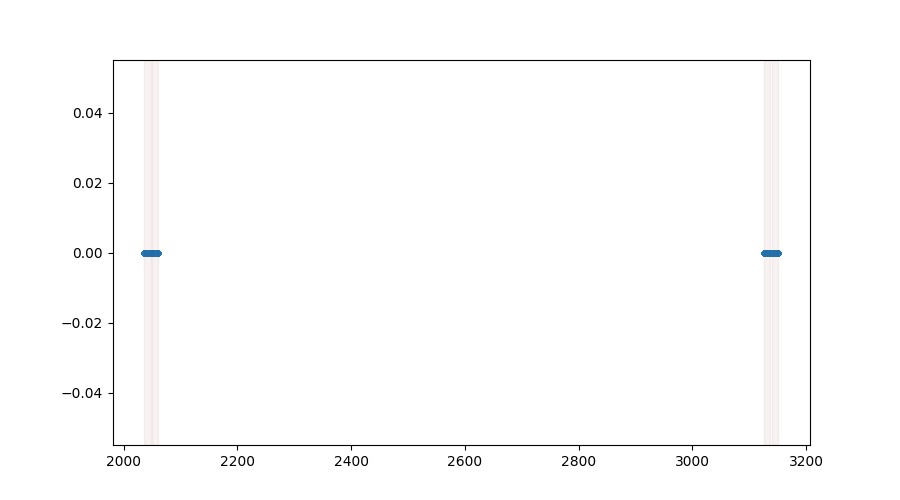


- - - - - 
number of discarded chunks: 0
number of used chunks: 4
- - - - - 


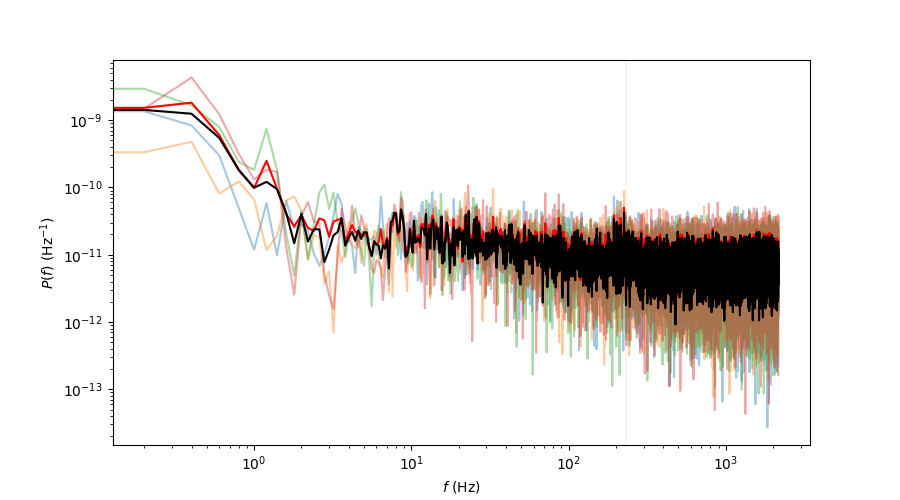

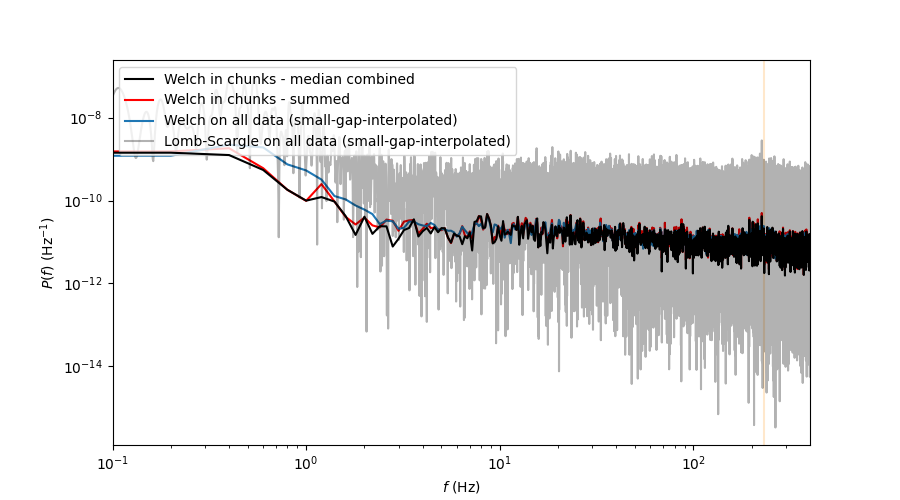

In [ ]:
# main toggles 
small_gap_size = 2000 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.5 # days
min_welch_chunk = 10 # days  
segment_size = 5 # days

fs_welch_median, psd_welch_median, used_chunk_sizes = run_full_welch(time_tess, flux_tess, small_gap_size, interpolate_window, min_welch_chunk, segment_size, fgrid_tess, plot_log = [True, True], extra_info = False, plot_chunks = True, plot_welch_comparison = True, injected_omegas = None, known_frequencies = [(2693/11.57)])

In [ ]:
# main toggles 
small_gap_size = 2000 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.5 # days

# step number one: identify big and small gaps
gap_start_times, gap_end_times, chunk_start_times, chunk_end_times, small_gap_start_times, small_gap_end_times, cadence = identify_gaps(time_tess, small_gap_size)

# step number two: interpolate the small gaps
times_interpolated_small, fluxes_interpolated_small = interpolate_small_gaps(time_tess, flux_tess, small_gap_start_times, small_gap_end_times, interpolate_window, cadence, plot = False)


#height of peak and divide by average in the region

- - - - - 
number of big gaps: 3
number of small gaps: 239
- - - - - 



239it [00:09, 26.53it/s]


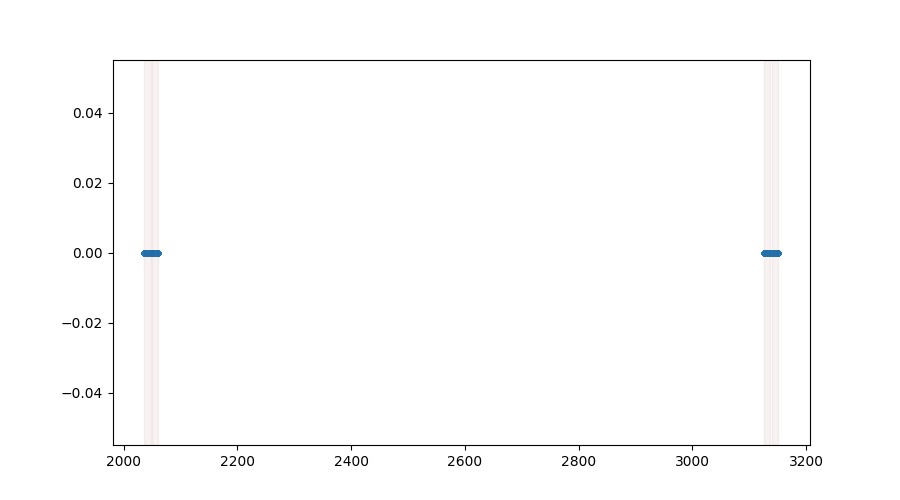


- - - - - 
number of discarded chunks: 0
number of used chunks: 4
- - - - - 
[11.850810844908665, 11.489530029963134, 10.00710689562311, 10.84607087142922]


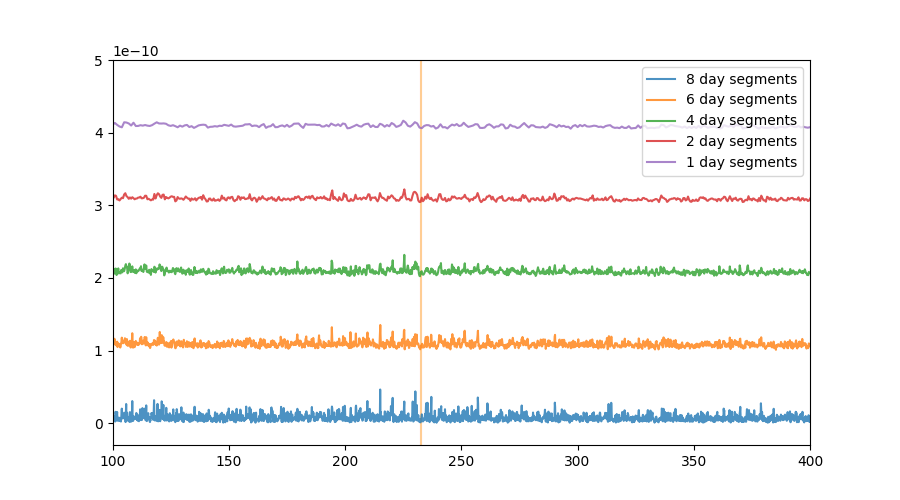

In [ ]:
# investigate how the welch changes with the segment size

min_welch_chunk = 10 # days  
segment_size = 9 # days



# keep the chunk sizes the same
chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = True, extra_info = False)

print (used_chunk_sizes)
fig, ax = plt.subplots(figsize = figsize)
for i,segment_size in enumerate([8,6,4,2,1]):

    fs_welch_median, psd_welch_median = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_tess, extra_info = False, plot_chunks = False, plot_results = False, plot_welch_comparison = False, known_frequencies = [(2693/11.57)], plot_log = [True, True])
    
    plt.plot(fs_welch_median , psd_welch_median + (i * 1e-10), label = '{} day segments'.format(segment_size), alpha = 0.8)

plt.xlim(100,400)
plt.ylim(-3e-11, 5e-10)
plt.legend()
plt.show()



- - - - - 
number of discarded chunks: 0
number of used chunks: 4
- - - - - 

- - - - - 
number of discarded chunks: 0
number of used chunks: 4
- - - - - 

- - - - - 
number of discarded chunks: 0
number of used chunks: 4
- - - - - 


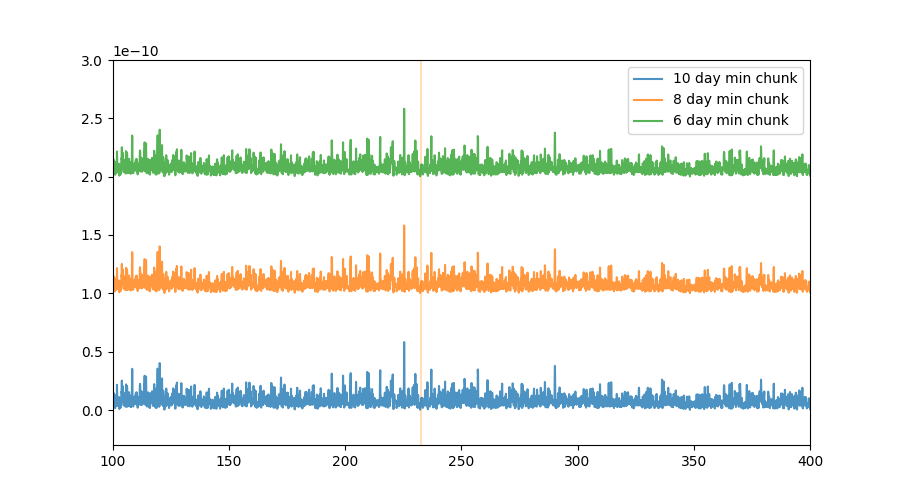

In [ ]:
# investigate how the welch changes min_welch_chunk

fig, ax = plt.subplots(figsize = figsize)

# keep the chunk sizes the same

min_welch_chunks = [10, 8, 6]

for i,min_welch_chunk in enumerate(min_welch_chunks):
    
    chunks_times, chunks_fluxes, used_chunk_sizes = which_chunks(times_interpolated_small, fluxes_interpolated_small, chunk_start_times, chunk_end_times, min_welch_chunk, plot_chunks = False, extra_info = False)

    segment_size = np.min(used_chunk_sizes)
    
    fs_welch_median, psd_welch_median = welch(times_interpolated_small, fluxes_interpolated_small, chunks_times, chunks_fluxes, segment_size, fgrid_kepler, extra_info = False, plot_chunks = False, plot_results = False, plot_welch_comparison = False, known_frequencies = [(2693/11.57)], plot_log = [True, True])
    
    plt.plot(fs_welch_median , psd_welch_median + (i * 1e-10), label = '{} day min chunk'.format(min_welch_chunk), alpha = 0.8)

plt.xlim(100,400)
plt.ylim(-3e-11, len(min_welch_chunks)* 1e-10)
plt.legend()
plt.show()


# Another TESS example

In [ ]:
lk.search_lightcurve('TIC {}'.format(tic_id), author = 'SPOC', exptime = 120)

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 02 2018   SPOC     120   441462736      0.0
  1 TESS Sector 29 2020   SPOC     120   441462736      0.0

In [ ]:
tic_id = 441462736

# make a lightkurve object
lc = lk.search_lightcurve('TIC {}'.format(tic_id), author = 'SPOC', exptime = 120)[0].download_all().stitch()


time_tess = lc.time.value
flux_tess = lc.flux.value

finite = np.isfinite(flux_tess) * np.isfinite(time_tess)

time_tess = time_tess[finite]
flux_tess = flux_tess[finite]

frequency_xlim = [0., 400] # these units are in cycles per day
fgrid_tess = get_fgrid(time_tess, 1., frequency_xlim)

# LS_power = LombScargle(time_tess, flux_tess).power(fgrid_tess)
# fig, ax = plt.subplots(figsize=figsize)
# plt.plot(fgrid_tess, LS_power)
# plt.tight_layout()
# plt.xlabel(r'Frequency [c/d]',fontsize = fontsize)
# plt.tight_layout()
# plt.loglog()


- - - - - 
number of big gaps: 2
number of small gaps: 269
- - - - - 



269it [00:00, 283.76it/s]


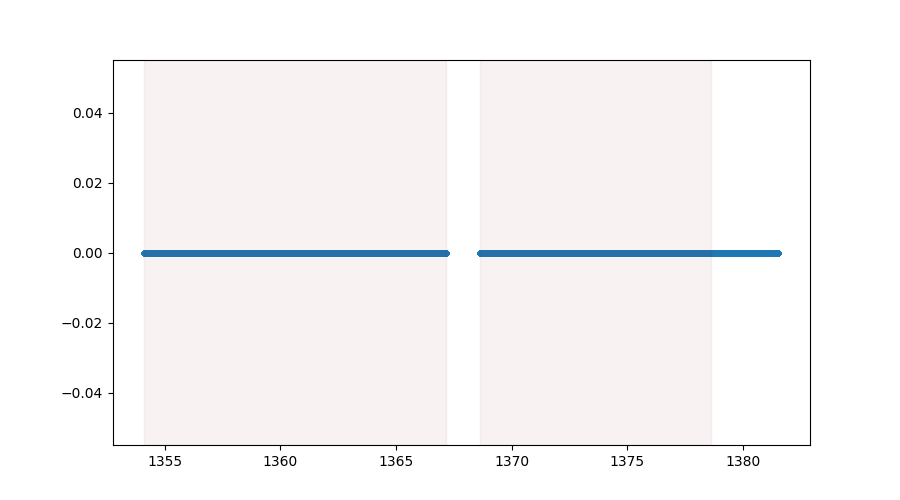


- - - - - 
number of discarded chunks: 1
number of used chunks: 2
- - - - - 
[13.044594630723623, 10.009621809799683]
[13.044594630723623, 10.009621809799683]


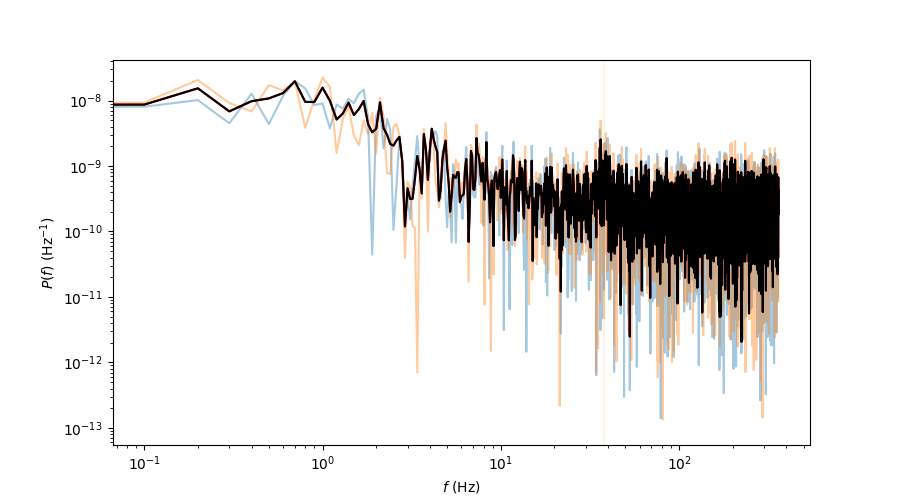

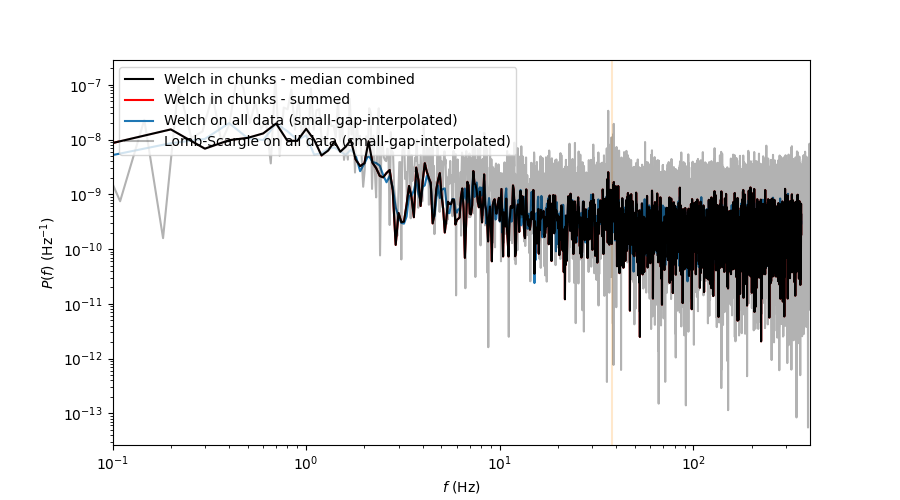

In [ ]:
# main toggles 
small_gap_size = 10 # anything gaps missing more than this number of data points are considered small and will be interpolated in step 2
interpolate_window = 0.5 # days
min_welch_chunk = 10 # days  
segment_size = 10 # days
known_frequencies = [(440/11.57)]

fs_welch_median, psd_welch_median, used_chunk_sizes = run_full_welch(time_tess, flux_tess, small_gap_size, interpolate_window, min_welch_chunk, segment_size, fgrid_tess, plot_log = [True, True], extra_info = False, plot_chunks = True, plot_welch_comparison = True, injected_omegas = None, known_frequencies = known_frequencies)

print (used_chunk_sizes)


In [ ]:
# RR Lyrae stars 
# tie it back to real life examples
# better version of pre-whitening

# show that jackknife or boostrap do not work in this scenario 
# need an estimator - don't have one... 
# implications of real life examples
# Take the Garcia frequency list 

In [ ]:
# start with example of just noise -- build it up. 

In [ ]:
def solar_like_oscillator(t, omega0, damping_ratio, noise_amplitude):
    # Simulate a solar-like oscillator with added noise
    omega_n = omega0 * np.sqrt(1 - damping_ratio**2)
    x = np.exp(-damping_ratio * omega0 * t) * np.cos(omega_n * t) + noise_amplitude * np.random.normal(size=len(t))
    return x

# Simulation parameters
duration = 10  # seconds
fs = 1000  # Sampling frequency
t = np.arange(0, duration, 1/fs)  # Time vector

# Solar-like oscillator parameters
omega0 = 2 * np.pi * 5  # Natural frequency
damping_ratio = 0.2  # Damping ratio
noise_amplitude = 0.1  # Amplitude of added noise

# Simulate solar-like oscillator
solar_oscillator = solar_like_oscillator(t, omega0, damping_ratio, noise_amplitude)

# Plot the simulated solar-like oscillator
plt.figure()
plt.plot(t, solar_oscillator)
plt.title('Solar-like Oscillator Simulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()